# pyzmq performance crossover

Sample plots from running `python collect.py` script to generate performance data.

PyZMQ's zero-copy implementation has a nontrivial overhead, due to the requirement to notify Python garbage collection when libzmq is done with a message from its IO thread. Performance optimizations over time and application/machine circumstances change where the crossover is, where zero-copy is more cost than benefit.

pyzmq 17 introduces `zmq.COPY_THRESHOLD`, a performance-tuning threshold,
where messages will not be copied even if sent with `copy=False`.
Based on these experiments,
the default value for `zmq.COPY_THRESHOLD` in pyzmq 17.0 is 64kB,
which seems to be a common crossover point.

In general, it is recommended to only use zero-copy for 'large' messages (at least 10s-100s of kB) because the bookkeeping overhead is significantly greater than small `memcpy` calls.

In [1]:
import matplotlib.pyplot as plt
import pickle

plt.ion()

def crossover(data, column):
    """Plot the crossover for copy=True|False"""
    for copy, df in data.groupby('copy'):
        plt.loglog(df['size'], df[column], 'v', label='copy' if copy else 'nocopy')
    plt.xlabel('size (B)')
    plt.ylabel('msgs/sec')
    plt.legend(loc=0)


def relative(data, column, scale='semilogx'):
    """Plot a normalized value showing relative performance"""
    copy_mean = data[data['copy']].groupby('size')[column].mean()
    no_copy = data[data['copy'] == False]
    reference = copy_mean[no_copy['size']]
    plot = getattr(plt, scale)
    plot(no_copy['size'], (no_copy[column] / reference.data), 'v')
    plt.xlabel("size (B)")


## Throughput

Throughput tests measure sending messages on a PUSH-PULL pair as fast as possible. These numbers count the time from first `recv` to the last.

In [2]:
with open('thr.pickle', 'rb') as f:
    thr = pickle.load(f)

In [3]:
thr.head()

,size,count,copy,poll,transport,sends,throughput
0,100,327680,True,False,ipc,475760.295347,264266.363135
1,100,655360,True,False,ipc,367704.492809,259478.511243
2,100,1310720,True,False,ipc,426573.892233,258967.498492
3,100,51200,False,False,ipc,34390.097183,34388.754455
4,100,102400,False,False,ipc,37725.643364,37723.441428


Plot the throughput performance vs msg size for copy/no-copy.
This should show us a crossover point where zero-copy starts to outperform copying.

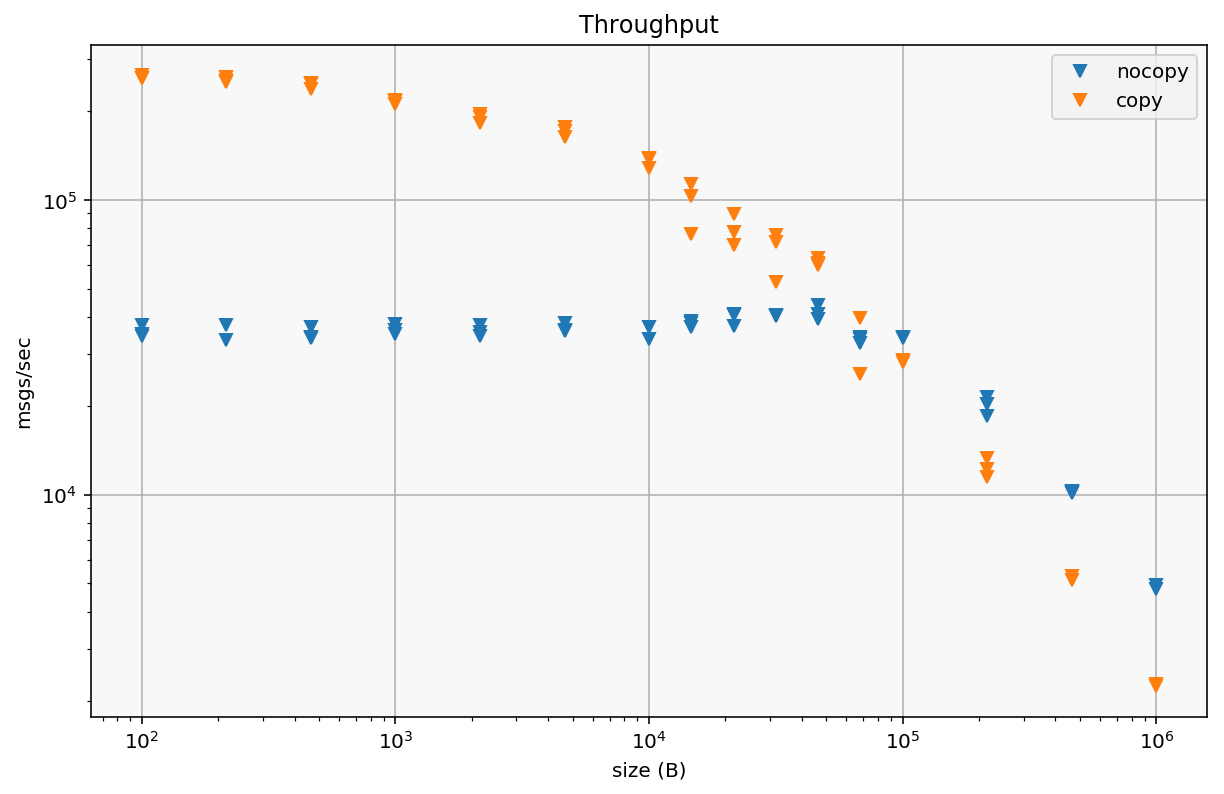

In [4]:
crossover(thr, 'throughput')
plt.title("Throughput");

Compare the maximum throughput for small messages:

In [5]:
print("zero-copy max msgs/sec: ~%.1e" % thr.where(thr['copy'] == False).throughput.max())
print("     copy max msgs/sec: ~%.1e" % thr.where(thr['copy']).throughput.max())

zero-copy max msgs/sec: ~4.4e+04
     copy max msgs/sec: ~2.6e+05


So that's a ~5x penalty when sending 100B messages.
It's still 40k msgs/sec, which isn't catastrophic,
but if you want to send small messages as fast as possible,
you can get closer to 250-500k msgs/sec if you skip the zero-copy logic.

We can see the relative gains of zero-copy by plotting zero-copy performance
normalized to message-copying performance

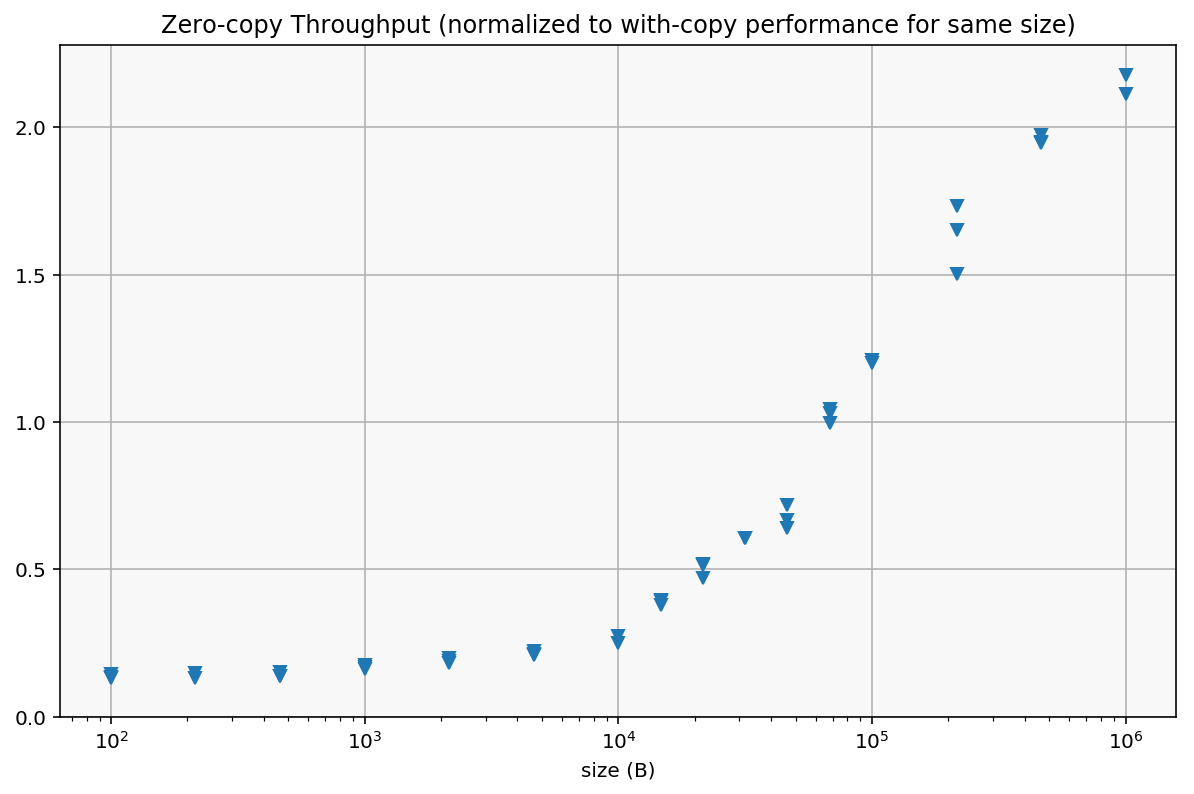

In [6]:
relative(thr, 'throughput')
plt.ylim(0, None)
plt.title("Zero-copy Throughput (normalized to with-copy performance for same size)");

So that's ~5x penalty for using zero-copy on 100B messages
and a ~2x win for using zero-copy in ~500kB messages.
THe crossover where the cost balances the benefit is in the vicinity of ~64kB.

This is why pyzmq 17 introduces the `zmq.COPY_THRESHOLD` behavior,
which sents a bound where `copy=False` can always be used,
and the zero-copy machinery will only be triggered for frames that are larger than this threshold.
The default for zmq.COPY_THRESHOLD in pyzmq-17.0 is 64kB,
based on these experiments.

### Send-only throughput

So far, we've only been measuring the time it takes to actually deliver all of those messages (total application throughput).

One of the big wins for zero-copy in pyzmq is that the the local `send` action is much less expensive for large messages because there is no `memcpy` in the handoff to zmq.
Plotting only the time it takes to *send* messages shows a much bigger win,
but similar crossover point.

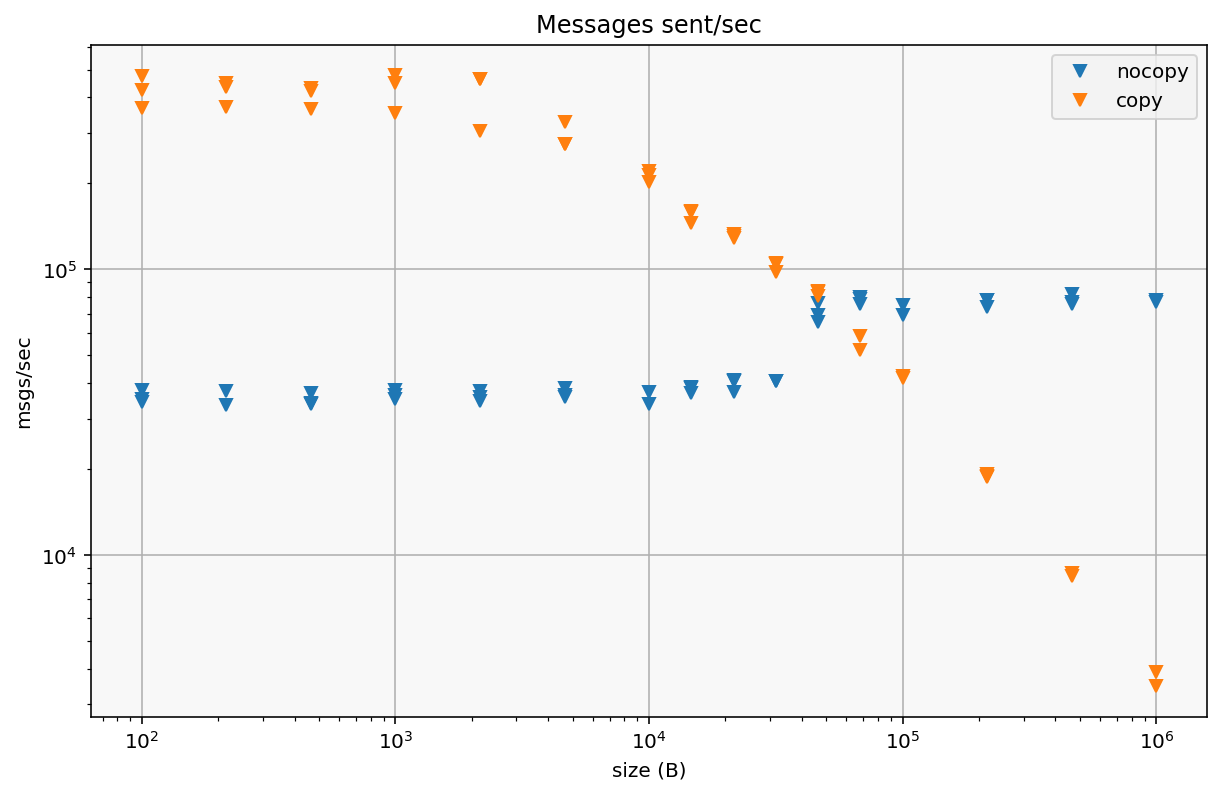

In [7]:
crossover(thr, 'sends')
plt.title("Messages sent/sec");

Scaled plot, showing ratio of zero-copy to copy throughput performance:

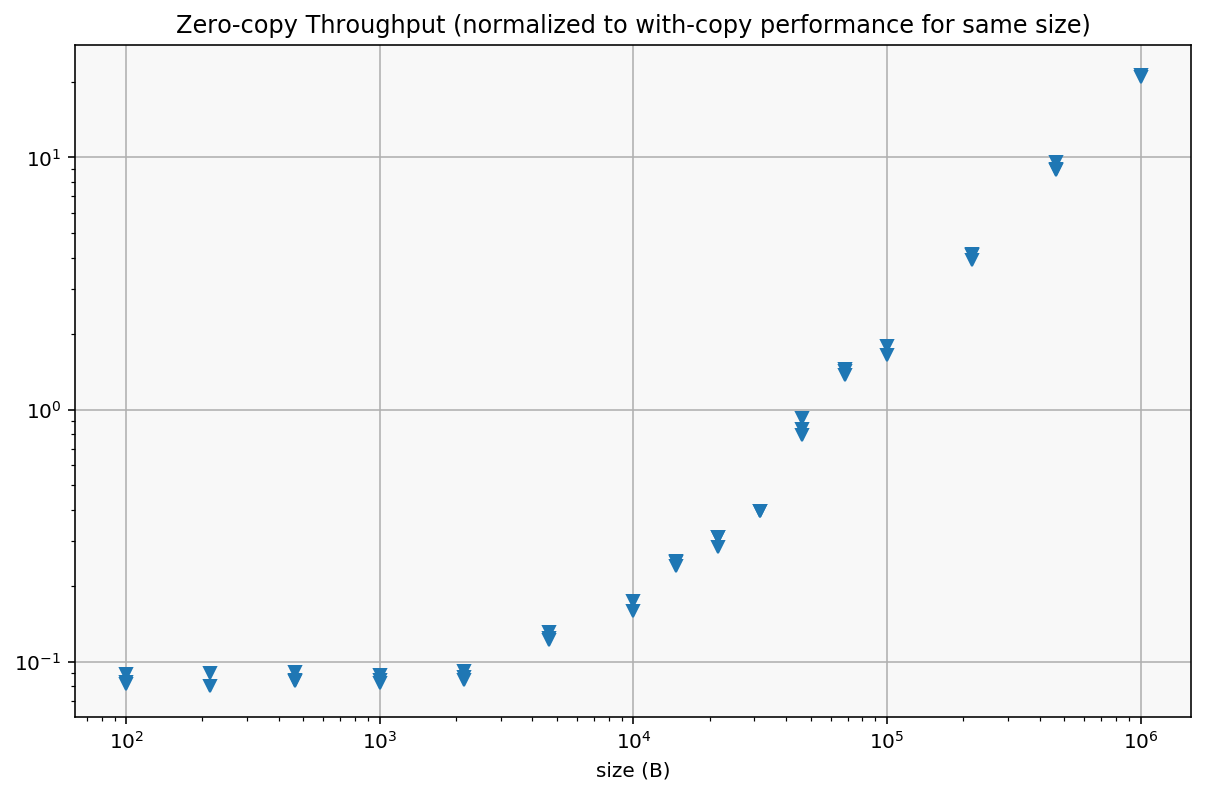

In [8]:
relative(thr, 'sends', scale='loglog')
plt.title("Zero-copy Throughput (normalized to with-copy performance for same size)");

The `socket.send` calls for ~1MB messages is ~20x faster with zero-copy than copy,
but it's also ~10x *slower* for very small messages.

Taking that into perspective, the penalty for zero-copy is ~10 µs per send:

In [9]:
copy_small = 1e6 / thr[thr['copy'] * thr['size'] == thr['size'].min()]['sends'].mean()
nocopy = 1e6 / thr[thr['copy'] == False]['sends']
penalty = nocopy - copy_small
print("Small copying send  : %.2fµs" % copy_per_send)
print("Small zero-copy send: %.2fµs ± %.2fµs" % (nocopy.mean(), nocopy.std()))
print("Penalty             : [%.2fµs - %.2fµs]" % (penalty.min(), penalty.max()))

NameError: name 'copy_per_send' is not defined

which is a pretty big deal for small sends that only take 2µs, but nothing for 1MB sends, where the memcpy can take almost a millisecond:

In [ ]:
copy_big = 1e6 / thr[thr['copy'] * thr['size'] == thr['size'].max()]['sends'].mean()
print("Big copying send (%i MB): %.2fµs" % (thr['size'].max() / 1e6, copy_big))

## Latency

Latency tests measure REQ-REP request/reply cycles, waiting for a reply before sending the next request.
This more directly measures the cost of sending and receiving a single message,
removing any instance of queuing up multiple sends in the background.

This differs from the throughput test, where many messages are in flight at once.
This is significant because much of the performance cost of zero-copy is in
contention between the garbage collection thread and the main thread.
If garbage collection events fire when the main thread is idle waiting for a message,
this has ~no extra cost.

In [ ]:
with open('lat.pickle', 'rb') as f:
    lat = pickle.load(f)

In [ ]:
crossover(lat, 'latency')
plt.ylabel("µs")
plt.title("Latency (µs)");

In [ ]:
relative(lat, 'latency')
plt.title("Relative increase in latency zero-copy / copy")
plt.ylim(0, None);

For the latency test, we see that there is much lower overhead to the zero-copy machinery when there are few messages in flight.
This is expected, because much of the performance cost comes from thread contention when the gc thread is working hard to keep up with the freeing of messages that zmq is done with.

The result is a much lower penalty for zero-copy of small messages (~10%)
and earlier crossover (~5kB).